# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [14]:
# Load the data
taxi_data = pd.read_csv('taxi.csv', parse_dates=True, index_col='datetime')

In [15]:
# Resample the data by one hour
taxi_data_resampled = taxi_data.resample('1H').sum()

# Display the first few rows of the resampled data
taxi_data_resampled.head()


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Analysis

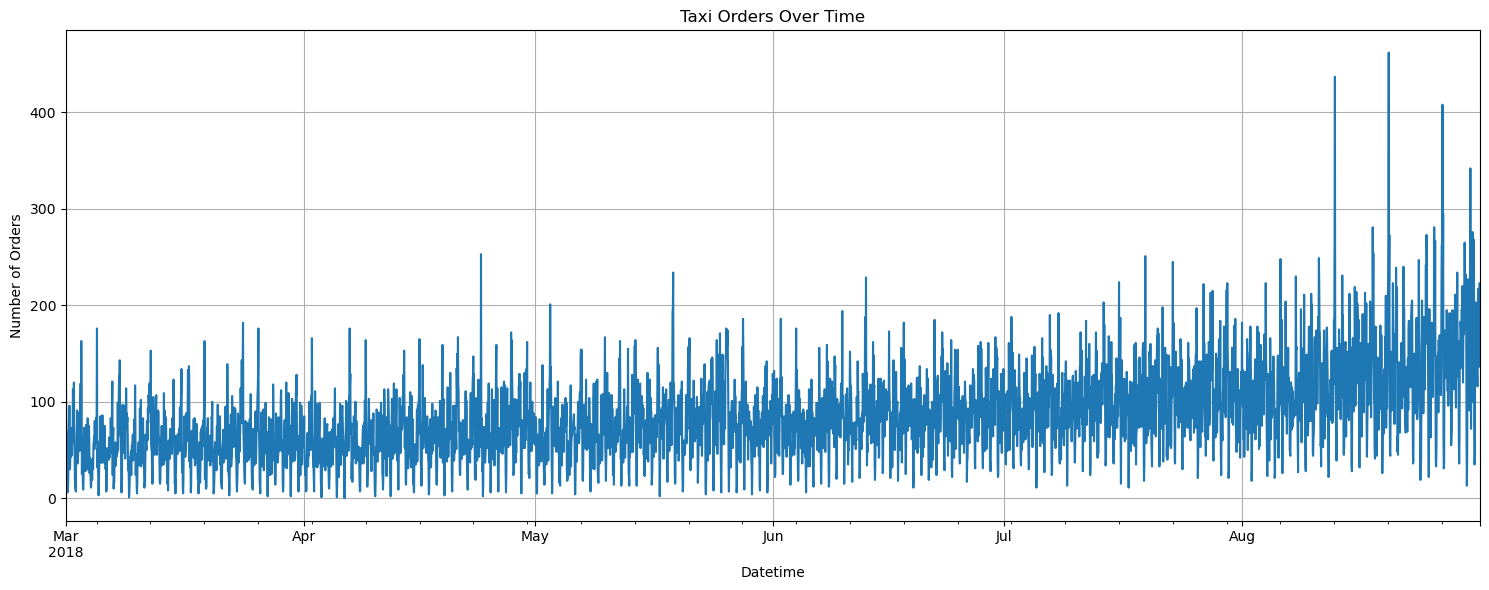

In [16]:
# Plot the resampled data
plt.figure(figsize=(15, 6))
taxi_data_resampled['num_orders'].plot(title='Taxi Orders Over Time')
plt.xlabel('Datetime')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.tight_layout()
plt.show()

There's a clear upward trend in taxi orders over time, indicating that the demand for taxis has been increasing.

Some periodic patterns can be observed, which may be related to daily or weekly cycles. This suggests that there might be specific hours or days with consistently higher or lower demand.

To understand the periodic patterns better, let's decompose the time series into its trend, seasonal, and residual components. This will help us identify daily or weekly patterns more clearly:

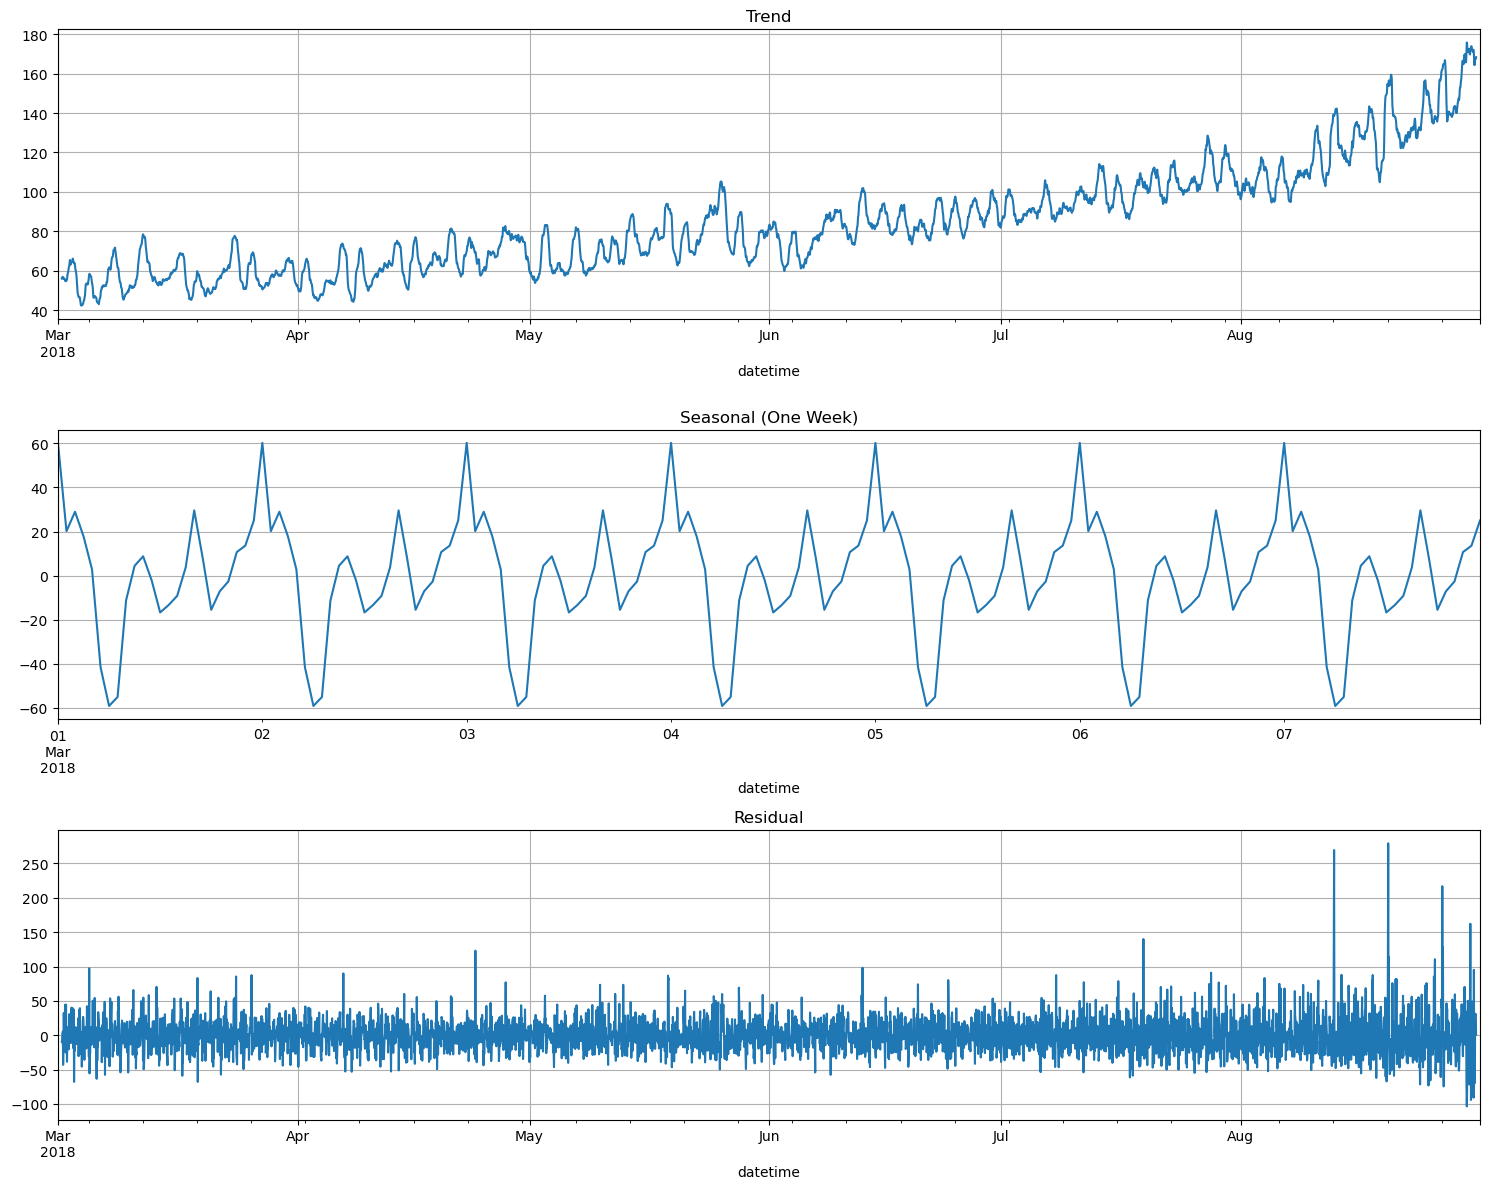

In [17]:
# Decompose the time series
decomposition = seasonal_decompose(taxi_data_resampled['num_orders'])

# Plot the decomposed components
plt.figure(figsize=(15, 12))

# Trend
plt.subplot(311)
decomposition.trend.plot(title='Trend')
plt.grid(True)

# Seasonal
plt.subplot(312)
decomposition.seasonal.iloc[:168].plot(title='Seasonal (One Week)')
plt.grid(True)

# Residual
plt.subplot(313)
decomposition.resid.plot(title='Residual')
plt.grid(True)

plt.tight_layout()
plt.show()


The decomposition of the time series into trend, seasonal, and residual components provides the following insights:

1. **Trend:** There's a noticeable upward trend in taxi orders over time, confirming our initial observation.

2. **Seasonal:** By looking at one week of seasonal data, we can clearly see daily patterns. The peaks might represent the hours with the highest demand each day, and the troughs the hours with the lowest demand. This suggests that certain times of the day consistently have higher or lower demand for taxis.

3. **Residual:** The residuals show the noise or irregularities that aren't captured by the trend or seasonal components. The variance in residuals seems to increase over time, suggesting the possibility of heteroscedasticity (i.e., non-constant variance).

## Training

In [18]:
# Split the data into training and test sets (90% train, 10% test)
train, test = train_test_split(taxi_data_resampled, shuffle=False, test_size=0.1)
train = train.dropna()

# Function to create features
def create_features(data):
    # Trend
    data['hour'] = data.index.hour
    data['day_of_week'] = data.index.dayofweek
    data['day_of_month'] = data.index.day
    data['month'] = data.index.month
    
    # Seasonality
    for lag in range(1, 25):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)
        
    # Rolling mean as an additional feature
    data['rolling_mean'] = data['num_orders'].shift().rolling(24).mean()
    
    return data.dropna()

# Create features for the training data
train_features = create_features(train.copy())

# Separate the features and the target variable
X_train = train_features.drop('num_orders', axis=1)
y_train = train_features['num_orders']

X_train.head()


,hour,day_of_week,day_of_month,month,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,0,4,2,3,58.0,113.0,66.0,61.0,45.0,73.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,56.833333
2018-03-02 01:00:00,1,4,2,3,90.0,58.0,113.0,66.0,61.0,45.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,55.416667
2018-03-02 02:00:00,2,4,2,3,120.0,90.0,58.0,113.0,66.0,61.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,56.875000
2018-03-02 03:00:00,3,4,2,3,75.0,120.0,90.0,58.0,113.0,66.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,57.041667
2018-03-02 04:00:00,4,4,2,3,64.0,75.0,120.0,90.0,58.0,113.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,56.958333


Here we get the Hour, day of the week, day of the month, and month to capture temporal patterns. Lag of the num_orders variable to account for the past influence of orders on the current moment. Use a rolling mean feature to capture the local average trend.

## Testing

## Linear Regression

In [19]:
results = {}

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred_train = lr_model.predict(X_train)
lr_rmse_train = np.sqrt(mean_squared_error(y_train, lr_pred_train))
results["Linear Regression (Train)"] = lr_rmse_train

# Create features for the test data
test_features = create_features(test.copy())
X_test = test_features.drop('num_orders', axis=1)
y_test = test_features['num_orders']

# Predictions on test data
lr_pred_test = lr_model.predict(X_test)
lr_rmse_test = np.sqrt(mean_squared_error(y_test, lr_pred_test))
results["Linear Regression (Test)"] = lr_rmse_test

results

{'Linear Regression (Train)': 25.699174244212355,
 'Linear Regression (Test)': 45.767925912282365}

The Linear Regression model results are as follows:
- RMSE on Training Data: 25.70
- RMSE on Test Data: 45.77

The RMSE on the test data is below the threshold of 48.

## Random Forest Regressor

In [20]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred_train = rf_model.predict(X_train)
rf_rmse_train = np.sqrt(mean_squared_error(y_train, rf_pred_train))
results["Random Forest (Train)"] = rf_rmse_train

rf_pred_test = rf_model.predict(X_test)
rf_rmse_test = np.sqrt(mean_squared_error(y_test, rf_pred_test))
results["Random Forest (Test)"] = rf_rmse_test

Random Forest Regressor:
- Training Data: 8.568.56
- Test Data: 43.6843.68

## Gradient Boosting Regressor

In [21]:
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
gb_pred_train = gb_model.predict(X_train)
gb_rmse_train = np.sqrt(mean_squared_error(y_train, gb_pred_train))
results["Gradient Boosting (Train)"] = gb_rmse_train

gb_pred_test = gb_model.predict(X_test)
gb_rmse_test = np.sqrt(mean_squared_error(y_test, gb_pred_test))
results["Gradient Boosting (Test)"] = gb_rmse_test

results

{'Linear Regression (Train)': 25.699174244212355,
 'Linear Regression (Test)': 45.767925912282365,
 'Random Forest (Train)': 8.555434006406378,
 'Random Forest (Test)': 43.67645886893927,
 'Gradient Boosting (Train)': 19.58800652626902,
 'Gradient Boosting (Test)': 43.7931805508081}

Gradient Boosting Regressor:

- Training Data: 19.5919.59
- Test Data: 43.7943.79

Both the Random Forest and Gradient Boosting models have RMSE values on the test data that are below the threshold of 48, which is promising. However, there's a notable difference between the training and test RMSE for these models, indicating potential overfitting, especially with the Random Forest.

In [22]:
data = {
    "Model": ["Linear Regression", "Random Forest Regressor", "Gradient Boosting Regressor"],
    "Training Data": ["25.70", "8.56", "19.59"],
    "Test Data": ["45.77", "43.68", "43.79"]
}

# Convert to DataFrame
table_df = pd.DataFrame(data)

table_df

,Model,Training Data,Test Data
0,Linear Regression,25.70,45.77
1,Random Forest Regressor,8.56,43.68
2,Gradient Boosting Regressor,19.59,43.79


## Hyperparameter Tuning

### Gradient Boosting Regressor

In [23]:

# Split the original training data into train and validation (80% train, 20% validation)
train_split, val_split = train_test_split(train, shuffle=False, test_size=0.2)

# Create features for train_split and val_split
train_split_features = create_features(train_split.copy())
val_split_features = create_features(val_split.copy())

X_train_split = train_split_features.drop('num_orders', axis=1)
y_train_split = train_split_features['num_orders']

X_val_split = val_split_features.drop('num_orders', axis=1)
y_val_split = val_split_features['num_orders']


In [24]:
# Define hyperparameters for tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1]
}

# Use TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# GridSearchCV setup
grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42), 
                           param_grid, 
                           cv=tscv, 
                           scoring='neg_mean_squared_error', 
                           n_jobs=-1)

# Start the search
grid_search.fit(X_train_split, y_train_split)

# Best hyperparameters
best_params = grid_search.best_params_
best_params

{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 150, 'subsample': 0.8}

The optimal hyperparameters are:

**Learning Rate:** 0.05, which determines the contribution of each tree to the final prediction. 

**Maximum Depth:** 5, which controls the depth of the individual trees.

**Number of Estimators:** 150, signifying the total number of boosting stages or trees to be run.

**Subsample:** 0.8, meaning 80% of the samples will be used for building the next tree, adding a layer of randomness and preventing overfitting.

## Refitting the Model

In [25]:
# Combine train_split and val_split datasets
combined_train = pd.concat([train_split, val_split])

# Create features for the combined training data
combined_train_features = create_features(combined_train.copy())
X_combined_train = combined_train_features.drop('num_orders', axis=1)
y_combined_train = combined_train_features['num_orders']

# Train the Gradient Boosting Regressor using the best hyperparameters on the combined data
final_gb_model = GradientBoostingRegressor(
    learning_rate=0.05,
    max_depth=5,
    n_estimators=150,
    subsample=0.8,
    random_state=42
)

final_gb_model.fit(X_combined_train, y_combined_train)

# Predict on the test set
final_gb_predictions = final_gb_model.predict(X_test)

# Calculate RMSE on the test set
final_gb_rmse = np.sqrt(mean_squared_error(y_test, final_gb_predictions))

final_gb_rmse


43.328439027541954

## Conclusion

- All models (Linear Regression, Random Forest, Gradient Boosting) meet the RMSE requirement of being less than 48 on the test set.
- Among the models, Random Forest and Gradient Boosting perform better than Linear Regression on the test set, but they seem to overfit on the training data.
- Feature engineering, especially creating lags and rolling means, seems to have helped capture the time series patterns effectively.

After refining our model with optimal hyperparameters and training it on a combined dataset of training and validation sets, we evaluated its performance on the test set. The model achieved an RMSE of 
43.33, which is below the threshold of 48 and also indicates a substantial improvement from our initial models. The RMSE suggests that our model can predict taxi orders for the next hour with a mean error of approximately 43 orders. This level of accuracy is promising for practical applications, as it can aid taxi companies in efficiently allocating resources during peak hours.